In [45]:
%matplotlib inline
from matplotlib import style
style.use('seaborn')
# style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

C:\Users\uwagb\AppData\Local\Temp\ipykernel_49944\52621352.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [47]:
datapath = r'C:\Users\uwagb\Downloads\mod 10\Starter_Code\Resources\hawaii.sqlite'
engine = create_engine(f"sqlite:///{datapath}")
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [48]:
Base.classes.keys()
['measurement', 'station']
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [49]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [50]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
year_calc_temp = calc_temps('2017-01-01', '2017-12-31')
year_calc_temp_df = pd.DataFrame(year_calc_temp, columns = ['temp_min', 'temp_avg', 'temp_max'])

average_temp = year_calc_temp_df['temp_avg']
peak_to_peak = year_calc_temp_df.iloc[0]['temp_max'] - year_calc_temp_df.iloc[0]['temp_min']

year_calc_temp_df

,temp_min,temp_avg,temp_max
0,58.0,74.14388,87.0


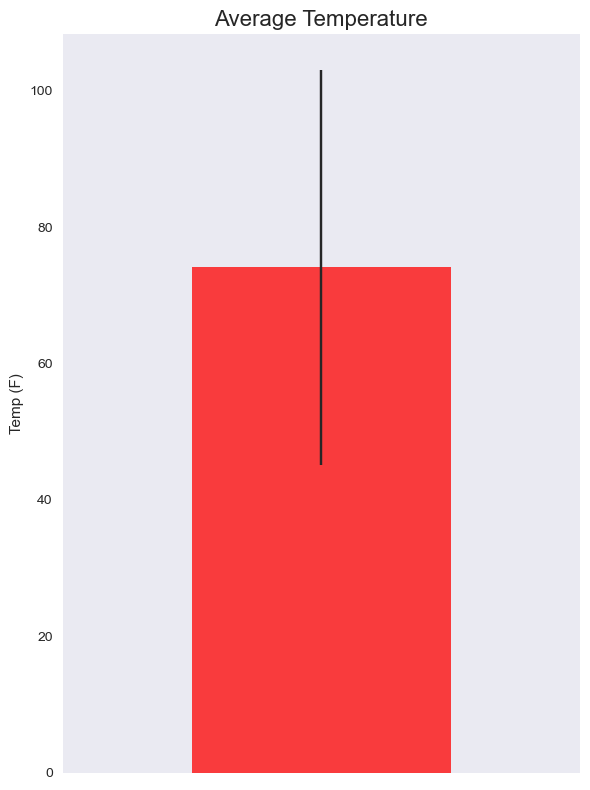

In [52]:
average_temp.plot(kind = 'bar', yerr = peak_to_peak, figsize = (6,8), alpha = 0.75, color = 'red')

# Use "Trip Avg Temp" as your Title
plt.title("Average Temperature", fontsize=16)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.tight_layout()
plt.savefig("./Average_temperature.png")
plt.show()

In [53]:
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

result = session.query(*sel).\
        filter(Station.station == Measurement.station).filter(Measurement.date >= '2017-08-01').\
        filter(Measurement.date <= '2017-08-07').group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

stations = pd.DataFrame(result, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36


In [54]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [55]:
start_date = '2017-08-01'
end_date = '2017-08-07'

In [56]:
dtobj = dt.datetime.strptime(start_date, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(end_date, '%Y-%m-%d')

travel_dates = []
normals =[]

while (dtobj <= enddtobj):
    travel_dates.append(dt.datetime.strftime(dtobj,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(dtobj,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    dtobj = dtobj + dt.timedelta(days = 1)

normals

[[67.0, 75.54, 83.0],
 [68.0, 75.60377358490567, 84.0],
 [70.0, 76.61111111111111, 85.0],
 [69.0, 76.71153846153847, 84.0],
 [69.0, 76.14814814814815, 82.0],
 [67.0, 76.25, 83.0],
 [71.0, 77.15686274509804, 83.0]]

In [57]:
travel_history = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
travel_history['Date'] = travel_dates
travel_history = travel_history.set_index("Date")
travel_history

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


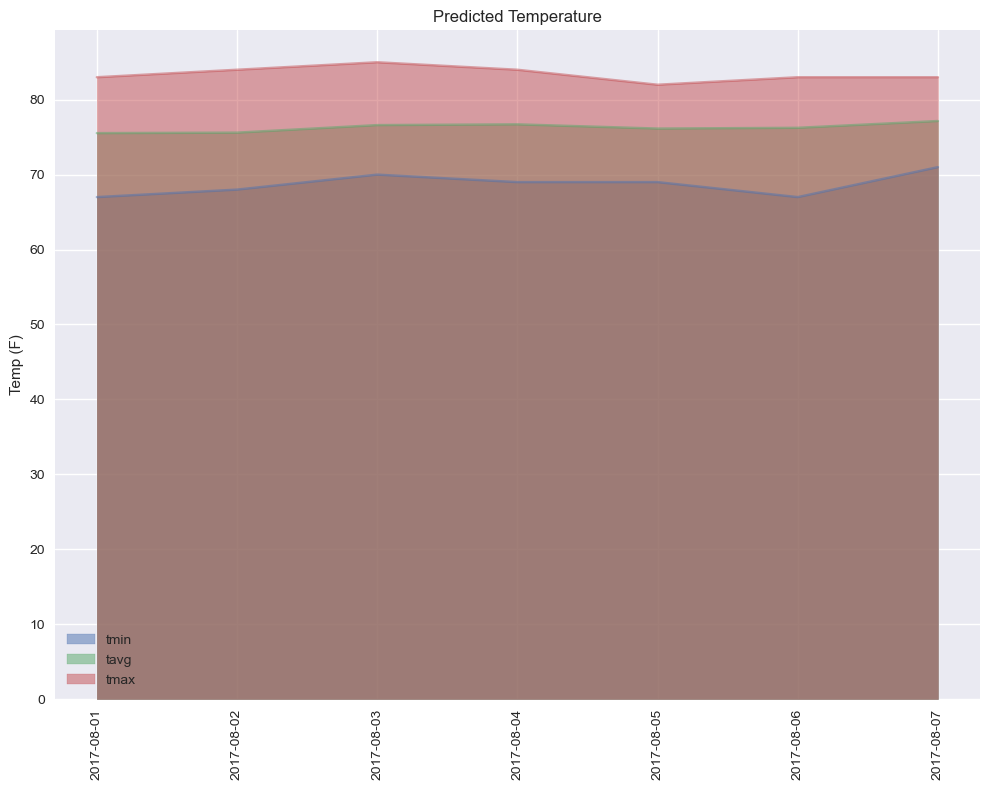

In [58]:
# Plot the daily normals as an area plot with `stacked=False`

travel_history.plot.area(figsize = (10, 8), stacked=False, title = "Predicted Temperature")
plt.xticks(rotation= 'vertical')

#make the labels
plt.xlabel('')
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.savefig("./Predicted_temperature(min_avg_max).png")
plt.show()